In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional
import numpy as np
import pandas as pd
from tqdm import tqdm
import os, sys
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import warnings
warnings.filterwarnings('ignore')

rd = '/home/anton/PycharmProjects/kaggle_competitions/rsna_cv/cvt_png'

/home/anton/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv('detect.csv')
dick = {fn: [] for fn in df['filename'].tolist()}
for row in range(len(df)):
    fn = df.iloc[row, 0]
    x1, y1, x2, y2 = df.iloc[row, 1], df.iloc[row, 2], df.iloc[row, 3], df.iloc[row, 4]
    label = df.iloc[row, 5]
    dick[fn].append([x1, y1, x2, y2, label])

In [4]:
df['y2'] += 0.9

95.17269544924156 168.4329054842474 186.1726954492416 256.0 L5/S1


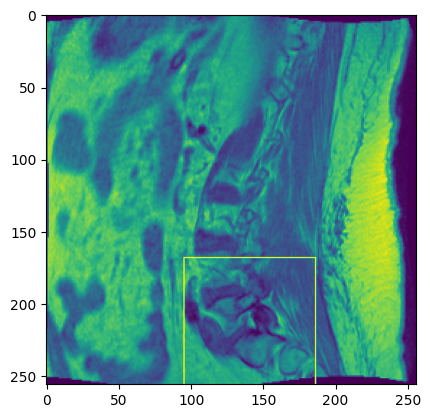

108.49273447820345 47.3223249669749 199.49273447820343 138.32232496697492 L1/L2
95.98018494055484 78.77278731836196 186.98018494055484 169.77278731836196 L2/L3
90.23117569352708 108.19418758256276 181.2311756935271 199.1941875825628 L3/L4
86.84940554821665 138.96829590488773 177.84940554821665 229.96829590488773 L4/L5
93.27476882430648 163.99339498018497 184.27476882430648 254.99339498018492 L5/S1


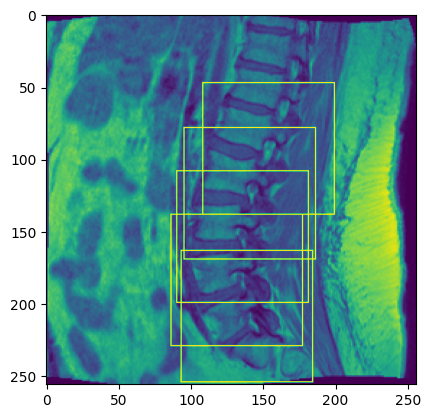

106.22520420070016 50.43990665110852 197.22520420070012 141.43990665110852 L1/L2
95.77012835472578 79.41540256709453 186.77012835472576 170.41540256709453 L2/L3
90.39323220536755 108.09218203033836 181.39323220536755 199.0921820303384 L3/L4


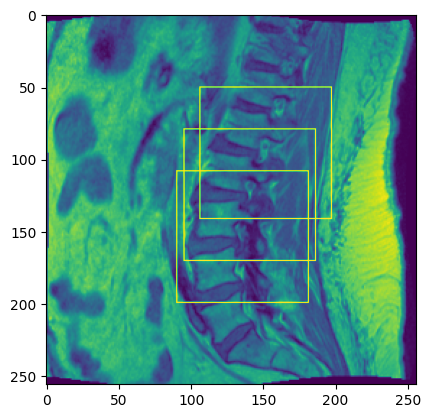

90.09451575262544 137.96382730455076 181.09451575262543 228.9638273045508 L4/L5


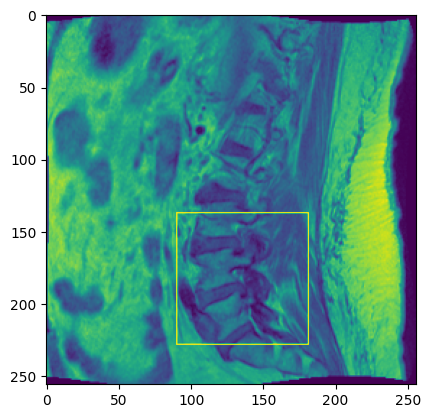

76.36591809775427 23.48084544253632 167.36591809775427 114.48084544253632 L1/L2
72.30779392338178 48.8441215323646 163.30779392338178 139.8441215323646 L2/L3
70.9550858652576 74.54557463672391 161.95508586525762 165.54557463672393 L3/L4


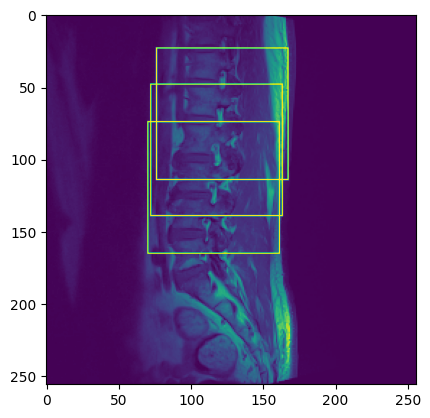

64.19154557463672 100.92338177014533 155.1915455746367 191.9233817701453 L4/L5
63.51519154557464 124.25759577278733 154.51519154557462 215.2575957727873 L5/S1


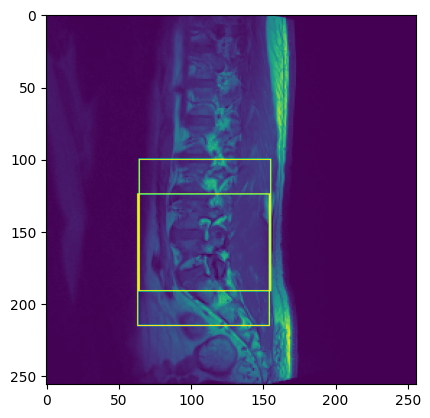

71.65701881331404 77.99855282199712 162.65701881331404 168.99855282199712 L3/L4
66.09985528219973 103.561505065123 157.0998552821997 194.561505065123 L4/L5


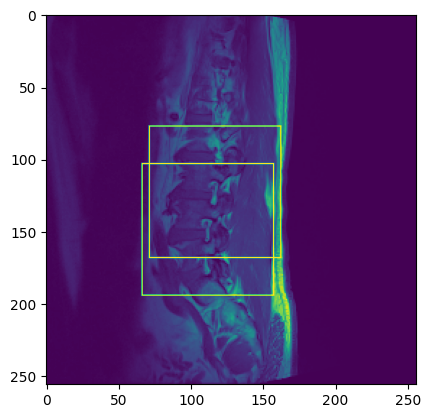

75.96011816838995 23.443131462333824 166.96011816838995 114.44313146233382 L1/L2
74.62083936324169 47.98986975397975 165.62083936324169 138.98986975397975 L2/L3
64.24746743849494 124.30824891461648 155.24746743849494 215.30824891461648 L5/S1


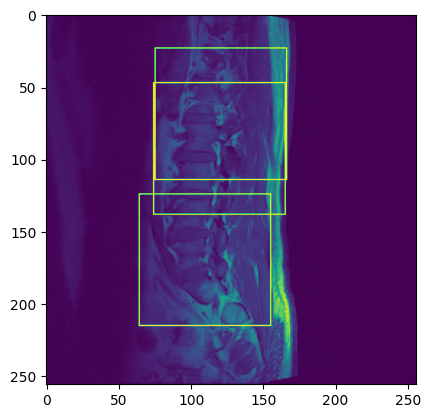

91.71362282309808 31.22860334555453 182.7136228230981 122.22860334555452 L1/L2
87.4899747937672 66.6309864802933 178.4899747937672 157.6309864802933 L2/L3
83.97026810265811 99.9508764894592 174.9702681026581 190.9508764894592 L3/L4
81.85844408799267 135.8738829055912 172.85844408799267 226.8738829055912 L4/L5
84.67420944087996 163.4669168194317 175.67420944087996 254.4669168194317 L5/S1


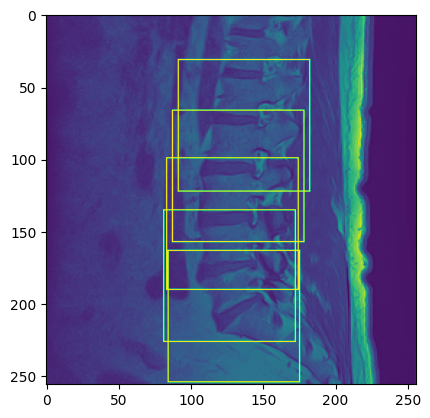

90.03950191808207 35.8980465352704 181.03950191808207 126.8980465352704 L1/L2
86.00003095236255 70.61470577695049 177.00003095236255 161.61470577695047 L2/L3
84.10976053175744 107.6893771323232 175.10976053175744 198.6893771323232 L3/L4
83.46250865367742 140.3444563938101 174.46250865367742 231.3444563938101 L4/L5
88.24781702710973 170.3182933762502 179.24781702710973 256.0 L5/S1


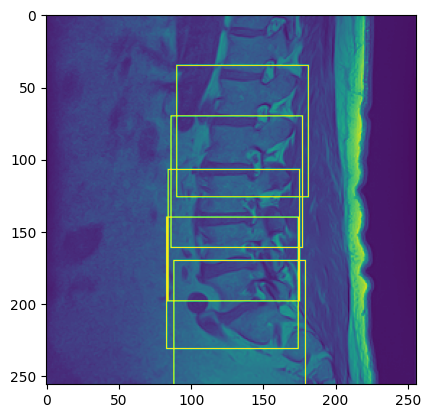

In [5]:
for fn in list(dick.keys())[:10]:
    image = cv2.imread(os.path.join(rd, fn))
    for bounding_box in dick[fn]:
        x1, y1, x2, y2, label = bounding_box
        print(x1, y1, x2, y2, label)
        image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255))
    cv2.imwrite('test.png', image)
    image = Image.open('test.png').convert('L')
    plt.imshow(image)
    plt.show()

In [6]:
import numpy as np

def IoU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


In [7]:
levels_to_i = {'L1/L2':1, 'L2/L3':2, 'L3/L4':3, 'L4/L5':4, 'L5/S1':5}

class DetectDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image).permute(2, 0, 1)
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if (self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['filename'] == image_id]  
        labels_ = records['labels'].tolist()
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.tensor(np.array([levels_to_i[label] for label in labels_]))
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target, image_id  



In [8]:
from sklearn.model_selection import train_test_split

def collate_fn(batch):
    return tuple(zip(*batch))

df_train, df_test = train_test_split(df, test_size=0.2, random_state=69)
train_dataset = DetectDataset(df_train, rd, None,True)
valid_dataset = DetectDataset(df_test, rd, None,True)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=False
)
 
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn,
    pin_memory=False
)

In [9]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0078,  ..., 0.0039, 0.0118, 0.0039],
          [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0118, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0078, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0078,  ..., 0.0039, 0.0118, 0.0039],
          [0.0039, 0.0078, 0.0078,  ..., 0.0078, 0.0118, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ...,

In [10]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False, pretrained_backbone=False)

In [11]:
num_classes = 6

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [12]:
from collections import OrderedDict

model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0002, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 20
itr=1
best_model = None
best_iou = 0.0
early_stopping = 3
es = 0

for epoch in range(num_epochs):
    if es == early_stopping:
        break
    
    model.train()
    total_loss = 0.0
    with tqdm(train_data_loader, total=len(train_data_loader), leave=True, position=0) as pbar:
        for images, targets, image_ids in pbar:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)   ##Return the loss

            losses = sum(loss for loss in loss_dict.values())
            if str(losses) == 'nan':
                losses = 1.0
            loss_value = losses.item()
            total_loss += loss_value * 2
            
            pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss_value:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            itr += 1

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    print(f"Epoch #{epoch} loss: {total_loss / len(train_data_loader)}")
    model.eval()
    
    with tqdm(valid_data_loader, total=len(valid_data_loader), leave=True, position=0) as pbar:
        total_iou, total_acc = 0, 0
        for images, targets, image_ids in pbar:
            with torch.no_grad():
                images = list(image.to(device) for image in images)
                predictions = model(images)
                boxes, boxes_true = [], []
                labels, labels_true = [], []
                
                for i in range(len(predictions)):
                    boxes.append(predictions[i]['boxes'].detach().cpu().numpy())
                    labels.append(predictions[i]['labels'].detach().cpu().numpy())
                    
                for i in range(len(targets)):
                    boxes_true.append(targets[i]['boxes'].detach().cpu().numpy())
                    labels_true.append(targets[i]['labels'].detach().cpu().numpy())
                    
                iou_mean = 0
                acc_mean = 0
                for i in range(len(boxes)):
                    if len(boxes[i]) == 0:
                        iou = 0.0
                        acc = 0.0
                    else:
                        iou = IoU(boxes[i][0], boxes_true[i][0])
                        acc = 1.0 if labels[i][0] == labels_true[i][0] else 0.0
                        
                    iou_mean += iou
                    acc_mean += acc
                    
                    
                    
                iou_mean /= len(images)
                acc_mean /= len(images)
                
                total_iou += iou_mean
                total_acc += acc_mean
                
                    
    print(f"Epoch #{epoch} loss: {total_iou / len(valid_data_loader)}  acc: {total_acc / len(valid_data_loader)}")
    
    if total_iou / len(valid_data_loader) > best_iou:
        best_iou = total_iou / len(valid_data_loader)
        best_model = model
        es = 0
    else:
        es += 1
        
        

100%|████████████| 953/953 [00:47<00:00, 20.05it/s, loss=0.719584, lr=2.000e-04]


Epoch #0 loss: 2.466720728846687


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 55.72it/s]


Epoch #0 loss: 0.4194748214599933  acc: 0.27765843179377014


100%|████████████| 953/953 [00:46<00:00, 20.67it/s, loss=1.015668, lr=1.000e-04]


Epoch #1 loss: 2.567460088389618


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 55.05it/s]


Epoch #1 loss: 0.4679683665727469  acc: 0.3040189760114572


100%|████████████| 953/953 [00:47<00:00, 20.01it/s, loss=0.521387, lr=5.000e-05]


Epoch #2 loss: 2.266244482143478


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 54.54it/s]


Epoch #2 loss: 0.48094667984654976  acc: 0.2930093089867526


100%|████████████| 953/953 [00:47<00:00, 20.01it/s, loss=0.820545, lr=2.500e-05]


Epoch #3 loss: 2.0056405684129888


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 54.23it/s]


Epoch #3 loss: 0.4886586068678515  acc: 0.27237737200143214


100%|████████████| 953/953 [00:47<00:00, 20.01it/s, loss=0.272173, lr=1.250e-05]


Epoch #4 loss: 1.7821311738658676


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 53.70it/s]


Epoch #4 loss: 0.47947381123434907  acc: 0.2604278553526674


100%|████████████| 953/953 [00:47<00:00, 19.95it/s, loss=0.172761, lr=6.250e-06]


Epoch #5 loss: 1.6720130181199981


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 53.37it/s]


Epoch #5 loss: 0.4704030200823197  acc: 0.2576530612244898


100%|████████████| 953/953 [00:47<00:00, 19.94it/s, loss=0.200271, lr=3.125e-06]


Epoch #6 loss: 1.609728190543644


100%|█████████████████████████████████████████| 399/399 [00:07<00:00, 52.74it/s]

Epoch #6 loss: 0.4652127448287901  acc: 0.25008950948800573


In [13]:
torch.__version__

'2.3.1+cu121'

In [14]:
torchvision.__version__

'0.18.1+cu121'

In [15]:
torch.save(best_model.state_dict(), 'detection_model.pt')